For this assignment, it originally used the resnet18 model. So we first tried the resnet18 model, and with this model, we tried the learning rate with 1e-2, 1e-3, 1e-4, and it turns out that 1e-3 has the best performance amongst all. However, as we didn’t want the learning rate to decay by 0.1 every 7 epochs, so we changed it to 9. For the model, we tried adding Dropout(0.5) and Dropout(0.4), but they didn’t really increase the performance of the model, and we just stopped using them. We also changed the batch size from original 64 to 32 and changed the num_workers to 2. We tried using data augmentation like Resize, RandomResizedCrop, RandomHorizontalFlip, and Normalize, but instead of increasing the performance like we hoped, they made the model perform worse, and that’s something we don’t really understand. Later, we changed the model from resnet18 to resnet34, and we also tried resnet50 and resnet101, but amongst these 4 models, resnet34 turns out provided the best performance, and we ended up using this model. With this model, we tried adding some layers at the very beginning, and the performance did increase a little bit, and this is our final result.


In [ ]:
from __future__ import print_function, division

import time
import os
import copy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from skimage import io, transform

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, models, transforms, utils

cudnn.benchmark = True
plt.ion()   # interactive mode

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
!unzip  /content/train_set -d /content/train_set

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/train_set/train_set/train_set/1954.jpg  
  inflating: /content/train_set/train_set/train_set/1955.jpg  
  inflating: /content/train_set/train_set/train_set/1956.jpg  
  inflating: /content/train_set/train_set/train_set/1957.jpg  
  inflating: /content/train_set/train_set/train_set/1958.jpg  
  inflating: /content/train_set/train_set/train_set/1959.jpg  
  inflating: /content/train_set/train_set/train_set/196.jpg  
  inflating: /content/train_set/train_set/train_set/1960.jpg  
  inflating: /content/train_set/train_set/train_set/1961.jpg  
  inflating: /content/train_set/train_set/train_set/1962.jpg  
  inflating: /content/train_set/train_set/train_set/1963.jpg  
  inflating: /content/train_set/train_set/train_set/1964.jpg  
  inflating: /content/train_set/train_set/train_set/1965.jpg  
  inflating: /content/train_set/train_set/train_set/1966.jpg  
  inflating: /content/train_set/train_set/train_set/1967.jpg  
  inflating: /content/train_s

In [ ]:
!unzip /content/test_set -d /content/test_set

Archive:  /content/test_set.zip
   creating: /content/test_set/test_set/test_set/
  inflating: /content/test_set/test_set/test_set/0.png  
  inflating: /content/test_set/test_set/test_set/1.png  
  inflating: /content/test_set/test_set/test_set/10.png  
  inflating: /content/test_set/test_set/test_set/100.png  
  inflating: /content/test_set/test_set/test_set/1000.png  
  inflating: /content/test_set/test_set/test_set/1001.png  
  inflating: /content/test_set/test_set/test_set/1002.png  
  inflating: /content/test_set/test_set/test_set/1003.png  
  inflating: /content/test_set/test_set/test_set/1004.png  
  inflating: /content/test_set/test_set/test_set/1005.png  
  inflating: /content/test_set/test_set/test_set/1006.png  
  inflating: /content/test_set/test_set/test_set/1007.png  
  inflating: /content/test_set/test_set/test_set/1008.png  
  inflating: /content/test_set/test_set/test_set/1009.png  
  inflating: /content/test_set/test_set/test_set/101.png  
  inflating: /content/test_s

In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#train_dir = "/kaggle/input/classification-of-an-out-of-distribution-dataset/train_set/train_set"
#csv_dir = "../input/classification-of-an-out-of-distribution-dataset/train_labels.csv"

train_dir='/content/train_set/train_set/train_set'
#path_to_test_images='/content/test_set/test_set'
csv_dir='/content/train_labels.csv'

#labels=pd.read_csv(train_dir)


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.ToPILImage(),
        #transforms.Resize((227, 227)),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor()
    ]),
}

In [ ]:
class DatasetCustom(Dataset):
    
    def __init__(self, root_dir, csv_path, transform=None):
        self.root = root_dir
        self.dataframe = pd.read_csv(csv_path)
        self.transform = transform
        
    def __len__(self):
        return self.dataframe.shape[0]-1
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        img_name = os.path.join(self.root,
                                self.dataframe.iloc[index, 0])
        
        image = io.imread(img_name)        
        
        label = (self.dataframe.iloc[index, 2])
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
train_dataset = DatasetCustom(train_dir, csv_dir, transform=data_transforms['train'])

In [ ]:
dataloader = DataLoader(train_dataset, batch_size=32,
                        shuffle=True, num_workers=2)

# Show some training images

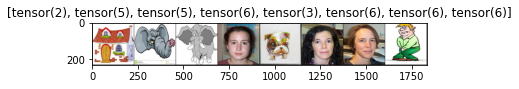

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
inputs, labels = next(iter(dataloader))
out = utils.make_grid(inputs[0:8])
imshow(out, title=[x for x in labels[0:8]])


# GPU availability

In [ ]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")

# Training loop function

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Model selection

In [ ]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.conv1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=(2, 2), stride=1, padding=0, bias=False),
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1, bias=False),
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=(5, 5), stride=1, padding=2, bias=False),
)

model.fc = nn.Sequential(#nn.Dropout(0.4), 
              nn.Linear(num_ftrs, 7), 
              nn.Softmax(dim=1))
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

# Loss function

In [ ]:
criterion = nn.CrossEntropyLoss()

# Optimizer and Scheduler

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=9, gamma=0.1)

# Training

In [ ]:
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------


100%|██████████| 190/190 [00:52<00:00,  3.64it/s]


train Loss: 1.8501 Acc: 0.3128


100%|██████████| 190/190 [00:16<00:00, 11.27it/s]


val Loss: 1.7423 Acc: 0.4564
Epoch 2/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.94it/s]


train Loss: 1.6689 Acc: 0.5163


100%|██████████| 190/190 [00:16<00:00, 11.20it/s]


val Loss: 1.6353 Acc: 0.5514
Epoch 3/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.93it/s]


train Loss: 1.5518 Acc: 0.6385


100%|██████████| 190/190 [00:16<00:00, 11.23it/s]


val Loss: 1.5302 Acc: 0.6737
Epoch 4/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.93it/s]


train Loss: 1.4671 Acc: 0.7184


100%|██████████| 190/190 [00:17<00:00, 11.17it/s]


val Loss: 1.4134 Acc: 0.7733
Epoch 5/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.94it/s]


train Loss: 1.4091 Acc: 0.7693


100%|██████████| 190/190 [00:17<00:00, 11.12it/s]


val Loss: 1.3882 Acc: 0.7921
Epoch 6/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.93it/s]


train Loss: 1.3544 Acc: 0.8312


100%|██████████| 190/190 [00:16<00:00, 11.19it/s]


val Loss: 1.2927 Acc: 0.9025
Epoch 7/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.94it/s]


train Loss: 1.3010 Acc: 0.8888


100%|██████████| 190/190 [00:16<00:00, 11.18it/s]


val Loss: 1.2558 Acc: 0.9322
Epoch 8/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.93it/s]


train Loss: 1.2632 Acc: 0.9205


100%|██████████| 190/190 [00:16<00:00, 11.19it/s]


val Loss: 1.2255 Acc: 0.9508
Epoch 9/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.93it/s]


train Loss: 1.2402 Acc: 0.9431


100%|██████████| 190/190 [00:17<00:00, 11.07it/s]


val Loss: 1.2076 Acc: 0.9654
Epoch 10/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.92it/s]


train Loss: 1.2245 Acc: 0.9545


100%|██████████| 190/190 [00:17<00:00, 11.16it/s]


val Loss: 1.2007 Acc: 0.9695
Epoch 11/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.93it/s]


train Loss: 1.2210 Acc: 0.9558


100%|██████████| 190/190 [00:17<00:00, 11.13it/s]


val Loss: 1.1986 Acc: 0.9715
Epoch 12/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.93it/s]


train Loss: 1.2157 Acc: 0.9616


100%|██████████| 190/190 [00:16<00:00, 11.19it/s]


val Loss: 1.1975 Acc: 0.9726
Epoch 13/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.93it/s]


train Loss: 1.2138 Acc: 0.9621


100%|██████████| 190/190 [00:16<00:00, 11.19it/s]


val Loss: 1.1952 Acc: 0.9746
Epoch 14/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.94it/s]


train Loss: 1.2150 Acc: 0.9634


100%|██████████| 190/190 [00:17<00:00, 11.10it/s]


val Loss: 1.1939 Acc: 0.9751
Epoch 15/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.92it/s]


train Loss: 1.2112 Acc: 0.9665


100%|██████████| 190/190 [00:17<00:00, 11.10it/s]


val Loss: 1.1925 Acc: 0.9764
Epoch 16/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.94it/s]


train Loss: 1.2115 Acc: 0.9647


100%|██████████| 190/190 [00:16<00:00, 11.18it/s]


val Loss: 1.1928 Acc: 0.9762
Epoch 17/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.95it/s]


train Loss: 1.2090 Acc: 0.9675


100%|██████████| 190/190 [00:16<00:00, 11.26it/s]


val Loss: 1.1908 Acc: 0.9776
Epoch 18/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.93it/s]


train Loss: 1.2070 Acc: 0.9698


100%|██████████| 190/190 [00:16<00:00, 11.19it/s]


val Loss: 1.1896 Acc: 0.9790
Epoch 19/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.93it/s]


train Loss: 1.2077 Acc: 0.9688


100%|██████████| 190/190 [00:17<00:00, 11.16it/s]


val Loss: 1.1898 Acc: 0.9786
Epoch 20/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.93it/s]


train Loss: 1.2054 Acc: 0.9696


100%|██████████| 190/190 [00:16<00:00, 11.24it/s]


val Loss: 1.1901 Acc: 0.9792
Epoch 21/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.94it/s]


train Loss: 1.2067 Acc: 0.9690


100%|██████████| 190/190 [00:17<00:00, 11.15it/s]


val Loss: 1.1898 Acc: 0.9792
Epoch 22/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.93it/s]


train Loss: 1.2046 Acc: 0.9711


100%|██████████| 190/190 [00:16<00:00, 11.24it/s]


val Loss: 1.1894 Acc: 0.9790
Epoch 23/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.93it/s]


train Loss: 1.2048 Acc: 0.9695


100%|██████████| 190/190 [00:17<00:00, 11.14it/s]


val Loss: 1.1892 Acc: 0.9797
Epoch 24/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.94it/s]


train Loss: 1.2066 Acc: 0.9700


100%|██████████| 190/190 [00:17<00:00, 11.17it/s]


val Loss: 1.1891 Acc: 0.9792
Epoch 25/25
----------


100%|██████████| 190/190 [00:48<00:00,  3.94it/s]


train Loss: 1.2040 Acc: 0.9703


100%|██████████| 190/190 [00:16<00:00, 11.21it/s]

val Loss: 1.1897 Acc: 0.9786
Training complete in 27m 17s
Best val Acc: 0.979706


# Test data loader

In [ ]:
class TestDatasetCustom(Dataset):
    
    def __init__(self, root_dir, transform=None):
        import glob
        self.root = root_dir
        files = glob.glob(root_dir+'/*.png')
        self.files = [root_dir + '/' + str(i) + '.png' for i in range(len(files))]
        self.transform = transform
    
    def file_getter(self):
        return self.files
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        
        if torch.is_tensor(index):
            index = index.tolist()
        
        image = io.imread(self.files[index])                
        
        if self.transform is not None:
            image = self.transform(image)
            
        img_name = self.files[index].split('/')[-1]
            
        return img_name, image

In [ ]:
test_dir = '/content/test_set/test_set/test_set'
test_dataset = TestDatasetCustom(test_dir, transform=data_transforms['train'])

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=1,
                        shuffle=False, num_workers=0)

# Saving the result

  0%|          | 1/3929 [00:00<36:02,  1.82it/s]

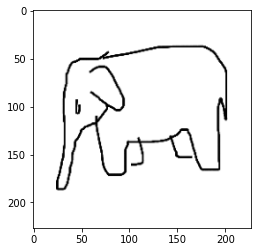

  0%|          | 2/3929 [00:01<33:39,  1.94it/s]

tensor([[0.0016, 0.0914, 0.0028, 0.0664, 0.4866, 0.3473, 0.0039]])


  0%|          | 10/3929 [00:03<22:07,  2.95it/s]

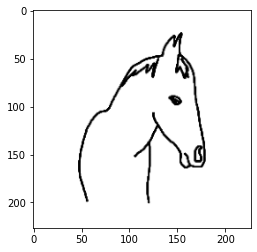

  0%|          | 11/3929 [00:04<25:06,  2.60it/s]

tensor([[1.7328e-04, 2.4912e-04, 4.4632e-05, 2.0289e-04, 9.9925e-01, 6.2875e-05,
         1.8976e-05]])


  1%|          | 20/3929 [00:07<21:44,  3.00it/s]

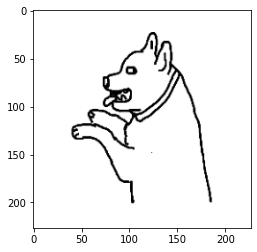

  1%|          | 21/3929 [00:07<24:37,  2.65it/s]

tensor([[6.2480e-04, 2.9225e-03, 1.2741e-03, 9.0673e-01, 8.5299e-02, 1.6765e-03,
         1.4778e-03]])


100%|██████████| 3929/3929 [22:12<00:00,  2.95it/s]


In [ ]:
total = 0
empty_dictionary = {'id': np.zeros((len(test_dataloader))), 'label': np.zeros((len(test_dataloader)))}
predicted_df = pd.DataFrame(data=empty_dictionary)
predicted_df['id'] = predicted_df['id'].apply(str)
predicted_df['label'] = predicted_df['label'].astype(int)
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for index, values in enumerate(tqdm(test_dataloader)):
        # calculate outputs by running images through the network
        image = values
        image_name = image[0]
        image_file = image[1]
        image_file = image_file.cpu().float()
        model_ft = model_ft.cpu()
        output = model_ft(image_file)
        
        _, predicted = torch.max(output.data, 1)
        
        if index==1 or index==10 or index==20:
            out = torchvision.utils.make_grid(image_file)
            imshow(out)
            print(output)
        
        predicted_df.at[index,'id'] = image_name[0]
        predicted_df.at[index,'label'] = str(predicted.numpy()[0])
        

In [ ]:
predicted_df.to_csv('predicted_20epoch.csv', index = False)